In [49]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.utilities import print_summary

In [50]:
# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

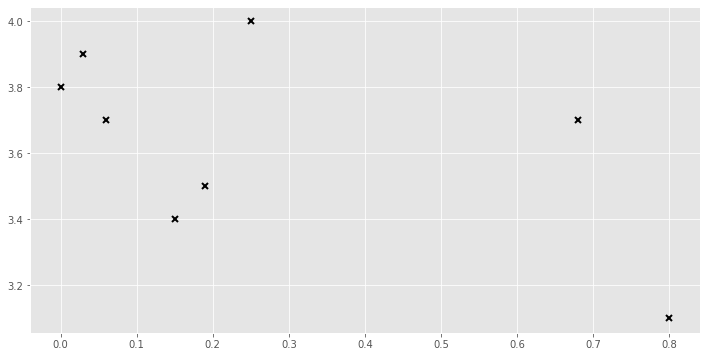

In [51]:
# data = np.genfromtxt("data/regression_1D.csv", delimiter=",")
# X = data[:, 0].reshape(-1, 1)
# Y = data[:, 1].reshape(-1, 1)
X = np.array([0, 0.03, 0.06, 0.15, 0.19, 0.25, 0.68, 0.8]).reshape(-1,1)
Y = np.array([3.8, 3.9, 3.7, 3.4, 3.5, 4.0, 3.7, 3.1]).reshape(-1,1)

_ = plt.plot(X, Y, "kx", mew=2)

In [12]:
X

array([[0.  ],
       [0.03],
       [0.06],
       [0.15],
       [0.19],
       [0.25],
       [0.68],
       [0.8 ]])

In [13]:
# X = np.array([0, 0.03, 0.06, 0.15, 0.19, 0.25, 0.68, 0.8]).reshape(-1,1)
# Y = np.array([1.1, 2.1, 3.1, 6.1, 7.2, 9.1, 17.2, 18.3]).reshape(-1,1)
# 
# _ = plt.plot(X, Y, "kx", mew=2)

In [14]:
k = gpflow.kernels.Matern52()

In [15]:
# k = gpflow.kernels.RBF()

In [43]:
meanf = gpflow.mean_functions.Linear()

In [44]:
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)

In [45]:
print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.0836665 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.0499711 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 1         │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧════════════

In [38]:
m.likelihood.variance.assign(0.01)
m.kernel.lengthscales.assign(0.3)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-1.0502256128148466>

In [39]:
m

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,9.119538301337803
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.30000000000000004
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.01000000000000004


In [46]:
opt = gpflow.optimizers.Scipy()

In [47]:
opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))
# print_summary(m)

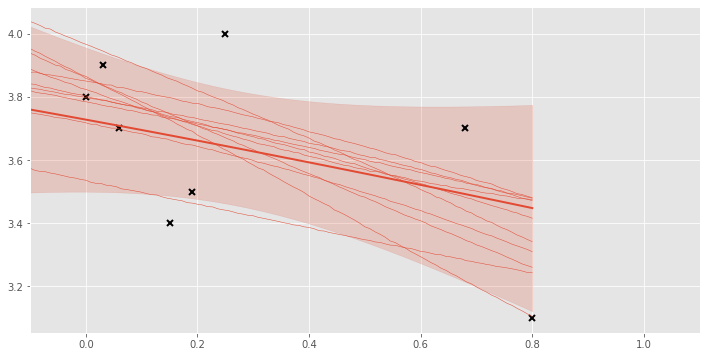

In [48]:
## generate test points for prediction
xx = np.linspace(-0.1, 0.8, 100).reshape(100, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
plt.figure(figsize=(12, 6))
plt.plot(X, Y, "kx", mew=2)
plt.plot(xx, mean, "C0", lw=2)
plt.fill_between(
    xx[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)

plt.plot(xx, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
_ = plt.xlim(-0.1, 1.1)

In [16]:
mean[50]

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([11.7283553])>

In [17]:
m.predict_f(np.array([0.5]).reshape(1,1))

(<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[14.71907156]])>,
 <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.00840942]])>)

In [5]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")
import tensorflow as tf

%matplotlib inline

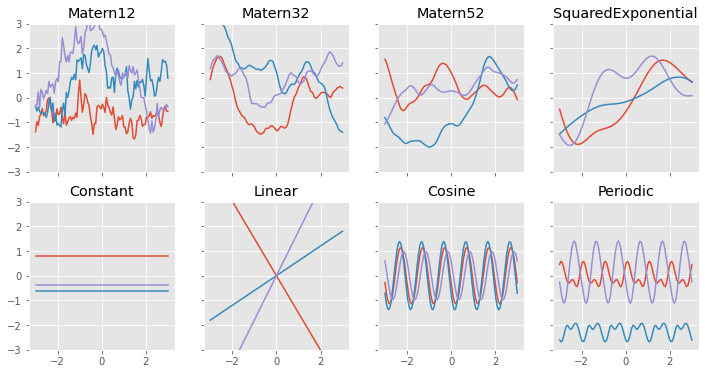

In [6]:
def plotkernelsample(k, ax, xmin=-3, xmax=3):
    xx = np.linspace(xmin, xmax, 100)[:, None]
    K = k(xx)
    ax.plot(xx, np.random.multivariate_normal(np.zeros(100), K, 3).T)
    ax.set_title(k.__class__.__name__)


np.random.seed(27)
f, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
plotkernelsample(gpflow.kernels.Matern12(), axes[0, 0])
plotkernelsample(gpflow.kernels.Matern32(), axes[0, 1])
plotkernelsample(gpflow.kernels.Matern52(), axes[0, 2])
plotkernelsample(gpflow.kernels.RBF(), axes[0, 3])
plotkernelsample(gpflow.kernels.Constant(), axes[1, 0])
plotkernelsample(gpflow.kernels.Linear(), axes[1, 1])
plotkernelsample(gpflow.kernels.Cosine(), axes[1, 2])
plotkernelsample(gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential()), axes[1, 3])
_ = axes[0, 0].set_ylim(-3, 3)